In [1]:
!rm -rf /kaggle/working/handwriting-generator-model
!git clone https://github.com/Shambu-K/handwriting-generator-model.git
!pip install fastdtw
%cd /kaggle/working/handwriting-generator-model/Code/STR_model

Cloning into 'handwriting-generator-model'...
remote: Enumerating objects: 1563, done.
remote: Counting objects: 100% (498/498), done.
remote: Compressing objects: 100% (310/310), done.
remote: Total 1563 (delta 209), reused 404 (delta 176), pack-reused 1065
Receiving objects: 100% (1563/1563), 438.09 MiB | 31.31 MiB/s, done.
Resolving deltas: 100% (661/661), done.
/kaggle/working/handwriting-generator-model/Code/STR_model


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader
from model import STR_Model, STR_Model_Longer_512, STR_Model_Longer_1024
from dataset.iam_dataloader import HandwritingDataset
from loss.stroke_loss import STR_Loss
from util.visualize_progress import visualize_progress, plot_losses
from fastdtw import fastdtw
from tqdm.notebook import tqdm
import os

In [8]:
def train(model, train_loader, loss_function, optimizer, device, epoch=0):
    # Setting the model to training mode
    model.train() 
    length = len(train_loader)
    # Looping over each batch from the training set 
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch}', total=length):  
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  
        output = model(data)  
        loss = loss_function(output, target) 
        loss.backward()
        # Updating the model parameters
        optimizer.step() 

        if batch_idx % 100 == 0:
            print(f'   Batch: {batch_idx:<4} | Width: {data.shape[-1]:<3} | Loss: {loss.item():.4f}')
            
    return loss.item()

def model_fit(model, train_loader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint, data_path, plot=True):
    train_losses = []
    for epoch in range(num_epochs):
        if plot: visualize_progress(model, device, data_path)
        print('=====================================================================\n')
        loss = train(model, train_loader, loss_function, optimizer, device, epoch+1)
        train_losses.append(loss)
        scheduler.step()
        if epoch % checkpoint == 0:
            model_file = f'./checkpoints/{model.__class__.__name__}_{epoch}_{int(loss)}.pth'
            torch.save(model.state_dict(), model_file) 
    
    return train_losses

# Util functions
def set_best_model(model, checkpoint_dir):
    ''' Set the model with least loss as the best model. '''
    best_loss = 100000
    best_model = None
    for file in os.listdir(checkpoint_dir):
        if file.endswith('.pth') and file.startswith(model.__class__.__name__):
            loss = int(file.split('_')[-1].split('.')[0])
            if loss < best_loss:
                best_loss = loss
                best_model = file
    if best_model is not None:
        model.load_state_dict(torch.load(os.path.join(checkpoint_dir, best_model)))
        print(f'Best model: {best_model}')

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(35)

# Training parameters
num_epochs = 100
batch_size = 16 # Archibald it is 32
checkpoint_interval = 1
learning_rate = 0.00005
lr_decay = 0.96

print('Using device:', device)

Using device: cuda


In [9]:
# Load data
root_dir = '/kaggle/input/iam-dataset-word-level/Resized_Dataset/Train'
# root_dir = '../../DataSet/IAM-Online/Resized_Dataset/Train/'
dataset = HandwritingDataset(root_dir, batch_size, device, max_allowed_width=400)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Preprocessing data: 100%|██████████| 2649/2649 [00:43<00:00, 60.68it/s]


In [10]:
# Model
model = STR_Model_Longer_1024().to(device)
set_best_model(model, './checkpoints/')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)
loss_function = STR_Loss(sos_weight=10)

Image id: 19938


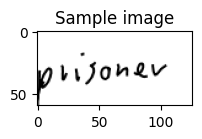

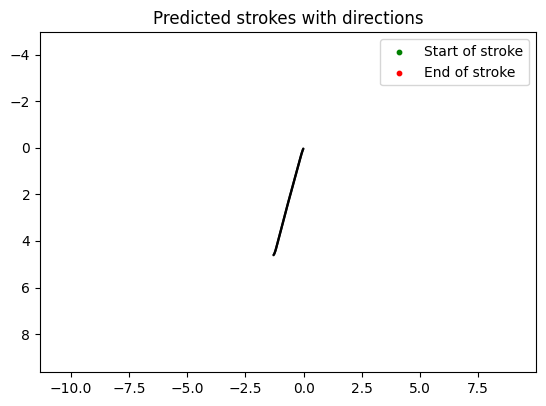

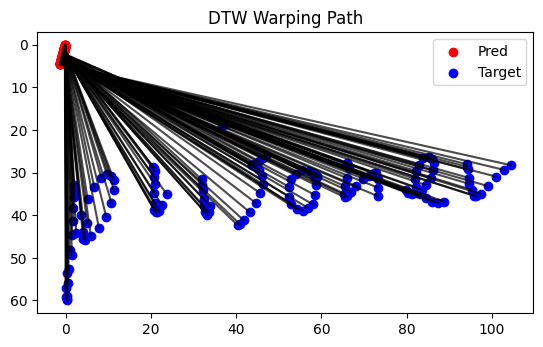

Epoch 1:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 524.1631
   Batch: 100  | Width: 46  | Loss: 356.8600
   Batch: 200  | Width: 56  | Loss: 336.5402
   Batch: 300  | Width: 64  | Loss: 328.8615
   Batch: 400  | Width: 72  | Loss: 336.6857
   Batch: 500  | Width: 78  | Loss: 294.0990
   Batch: 600  | Width: 84  | Loss: 306.4356
   Batch: 700  | Width: 90  | Loss: 384.5591
   Batch: 800  | Width: 96  | Loss: 326.7213
   Batch: 900  | Width: 102 | Loss: 399.5124
   Batch: 1000 | Width: 108 | Loss: 370.5745
   Batch: 1100 | Width: 114 | Loss: 368.8075
   Batch: 1200 | Width: 120 | Loss: 415.5394
   Batch: 1300 | Width: 126 | Loss: 425.9016
   Batch: 1400 | Width: 134 | Loss: 480.3051
   Batch: 1500 | Width: 140 | Loss: 445.8499
   Batch: 1600 | Width: 148 | Loss: 435.3803
   Batch: 1700 | Width: 156 | Loss: 433.5562
   Batch: 1800 | Width: 166 | Loss: 523.4797
   Batch: 1900 | Width: 176 | Loss: 595.8703
   Batch: 2000 | Width: 188 | Loss: 620.0203
   Batch: 2100 | Width: 200 | Loss: 577.6702
   Batch: 

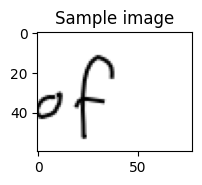

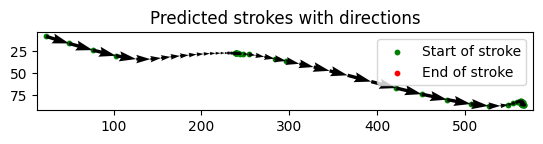

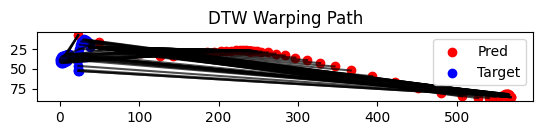

Epoch 2:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 626.0171
   Batch: 100  | Width: 46  | Loss: 298.5280
   Batch: 200  | Width: 56  | Loss: 282.5657
   Batch: 300  | Width: 64  | Loss: 321.4157
   Batch: 400  | Width: 72  | Loss: 279.3214
   Batch: 500  | Width: 78  | Loss: 268.5514
   Batch: 600  | Width: 84  | Loss: 262.0357
   Batch: 700  | Width: 90  | Loss: 341.5211
   Batch: 800  | Width: 96  | Loss: 253.5342
   Batch: 900  | Width: 102 | Loss: 346.1260
   Batch: 1000 | Width: 108 | Loss: 337.2006
   Batch: 1100 | Width: 114 | Loss: 302.9970
   Batch: 1200 | Width: 120 | Loss: 375.6308
   Batch: 1300 | Width: 126 | Loss: 395.5190
   Batch: 1400 | Width: 134 | Loss: 371.9241
   Batch: 1500 | Width: 140 | Loss: 381.3516
   Batch: 1600 | Width: 148 | Loss: 442.9062
   Batch: 1700 | Width: 156 | Loss: 398.0393
   Batch: 1800 | Width: 166 | Loss: 484.4851
   Batch: 1900 | Width: 176 | Loss: 537.8798
   Batch: 2000 | Width: 188 | Loss: 540.8138
   Batch: 2100 | Width: 200 | Loss: 512.9219
   Batch: 

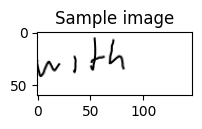

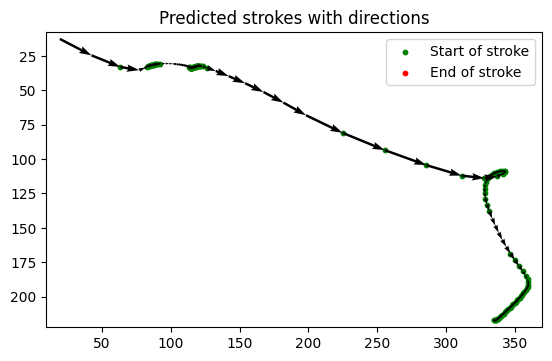

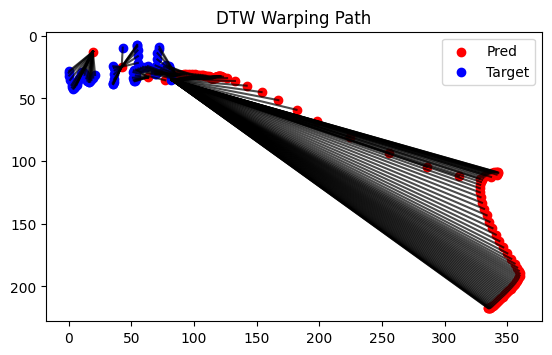

Epoch 3:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 617.5882
   Batch: 100  | Width: 46  | Loss: 283.8788
   Batch: 200  | Width: 56  | Loss: 268.7844
   Batch: 300  | Width: 64  | Loss: 287.2001
   Batch: 400  | Width: 72  | Loss: 253.3247
   Batch: 500  | Width: 78  | Loss: 245.2148
   Batch: 600  | Width: 84  | Loss: 249.3118
   Batch: 700  | Width: 90  | Loss: 321.0524
   Batch: 800  | Width: 96  | Loss: 261.3681
   Batch: 900  | Width: 102 | Loss: 319.6300
   Batch: 1000 | Width: 108 | Loss: 303.5866
   Batch: 1100 | Width: 114 | Loss: 308.7238
   Batch: 1200 | Width: 120 | Loss: 331.4619
   Batch: 1300 | Width: 126 | Loss: 400.9929
   Batch: 1400 | Width: 134 | Loss: 391.8360
   Batch: 1500 | Width: 140 | Loss: 372.9695
   Batch: 1600 | Width: 148 | Loss: 419.7354
   Batch: 1700 | Width: 156 | Loss: 449.0301
   Batch: 1800 | Width: 166 | Loss: 520.6634
   Batch: 1900 | Width: 176 | Loss: 440.2063
   Batch: 2000 | Width: 188 | Loss: 533.9033
   Batch: 2100 | Width: 200 | Loss: 484.0404
   Batch: 

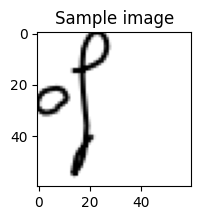

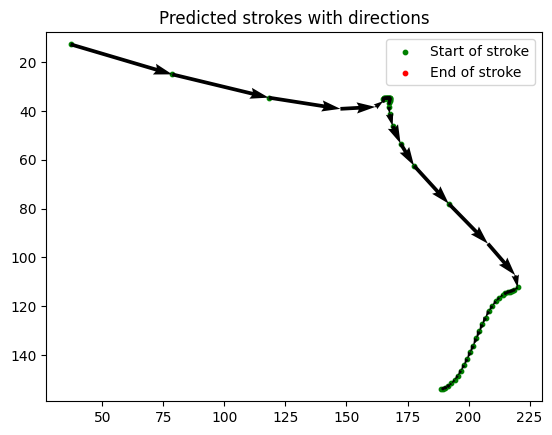

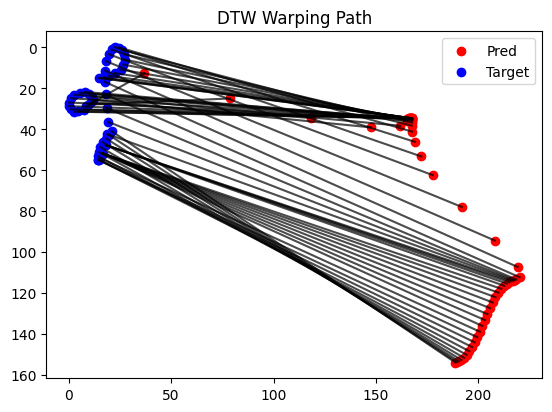

Epoch 4:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 458.5486
   Batch: 100  | Width: 46  | Loss: 292.8344
   Batch: 200  | Width: 56  | Loss: 258.6845
   Batch: 300  | Width: 64  | Loss: 278.7866
   Batch: 400  | Width: 72  | Loss: 236.9620
   Batch: 500  | Width: 78  | Loss: 232.7626
   Batch: 600  | Width: 84  | Loss: 289.2536
   Batch: 700  | Width: 90  | Loss: 285.1124
   Batch: 800  | Width: 96  | Loss: 253.4115
   Batch: 900  | Width: 102 | Loss: 332.7505
   Batch: 1000 | Width: 108 | Loss: 313.6151
   Batch: 1100 | Width: 114 | Loss: 311.0963
   Batch: 1200 | Width: 120 | Loss: 320.3263
   Batch: 1300 | Width: 126 | Loss: 375.5862
   Batch: 1400 | Width: 134 | Loss: 370.8512
   Batch: 1500 | Width: 140 | Loss: 372.1346
   Batch: 1600 | Width: 148 | Loss: 395.1463
   Batch: 1700 | Width: 156 | Loss: 428.2907
   Batch: 1800 | Width: 166 | Loss: 459.7629
   Batch: 1900 | Width: 176 | Loss: 441.8792
   Batch: 2000 | Width: 188 | Loss: 542.9083
   Batch: 2100 | Width: 200 | Loss: 505.1374
   Batch: 

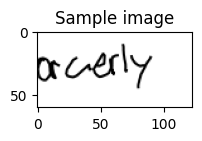

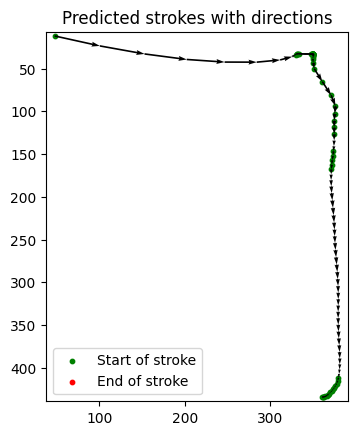

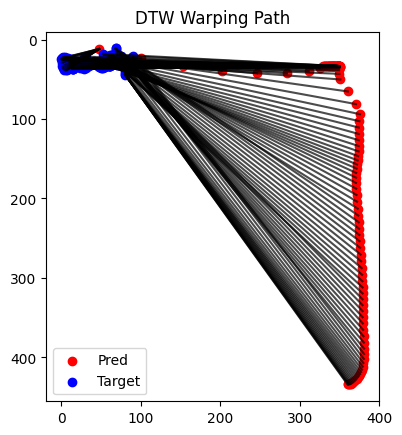

Epoch 5:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 466.2441
   Batch: 100  | Width: 46  | Loss: 285.7938
   Batch: 200  | Width: 56  | Loss: 262.7772
   Batch: 300  | Width: 64  | Loss: 292.6160
   Batch: 400  | Width: 72  | Loss: 226.3248
   Batch: 500  | Width: 78  | Loss: 222.1684
   Batch: 600  | Width: 84  | Loss: 311.7754
   Batch: 700  | Width: 90  | Loss: 300.7876
   Batch: 800  | Width: 96  | Loss: 247.5186
   Batch: 900  | Width: 102 | Loss: 345.9736
   Batch: 1000 | Width: 108 | Loss: 318.2795
   Batch: 1100 | Width: 114 | Loss: 352.4429
   Batch: 1200 | Width: 120 | Loss: 348.1695
   Batch: 1300 | Width: 126 | Loss: 393.8444
   Batch: 1400 | Width: 134 | Loss: 401.2147
   Batch: 1500 | Width: 140 | Loss: 378.9384
   Batch: 1600 | Width: 148 | Loss: 418.9909
   Batch: 1700 | Width: 156 | Loss: 447.5234
   Batch: 1800 | Width: 166 | Loss: 443.3971
   Batch: 1900 | Width: 176 | Loss: 432.8172
   Batch: 2000 | Width: 188 | Loss: 498.1675
   Batch: 2100 | Width: 200 | Loss: 474.2478
   Batch: 

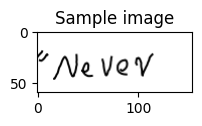

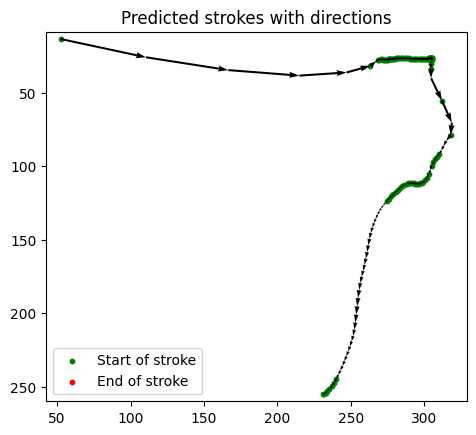

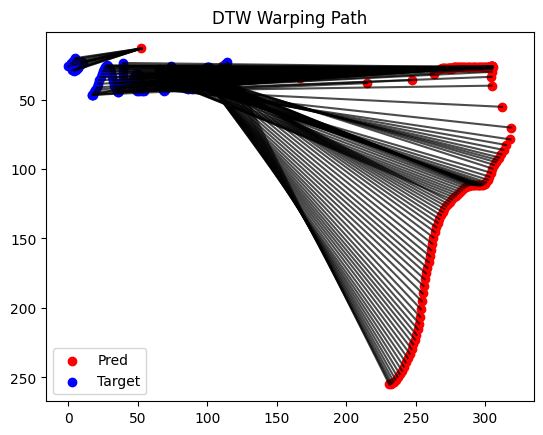

Epoch 6:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 451.8431
   Batch: 100  | Width: 46  | Loss: 284.9476
   Batch: 200  | Width: 56  | Loss: 273.9600
   Batch: 300  | Width: 64  | Loss: 286.9537
   Batch: 400  | Width: 72  | Loss: 279.5290
   Batch: 500  | Width: 78  | Loss: 226.6941
   Batch: 600  | Width: 84  | Loss: 264.7022
   Batch: 700  | Width: 90  | Loss: 300.9387
   Batch: 800  | Width: 96  | Loss: 256.3257
   Batch: 900  | Width: 102 | Loss: 320.2532
   Batch: 1000 | Width: 108 | Loss: 310.9813
   Batch: 1100 | Width: 114 | Loss: 320.6541
   Batch: 1200 | Width: 120 | Loss: 308.9730
   Batch: 1300 | Width: 126 | Loss: 348.1114
   Batch: 1400 | Width: 134 | Loss: 398.3857
   Batch: 1500 | Width: 140 | Loss: 347.4180
   Batch: 1600 | Width: 148 | Loss: 408.3466
   Batch: 1700 | Width: 156 | Loss: 391.7285
   Batch: 1800 | Width: 166 | Loss: 472.1428
   Batch: 1900 | Width: 176 | Loss: 391.7934
   Batch: 2000 | Width: 188 | Loss: 470.2370
   Batch: 2100 | Width: 200 | Loss: 487.7488
   Batch: 

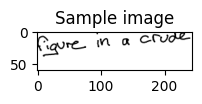

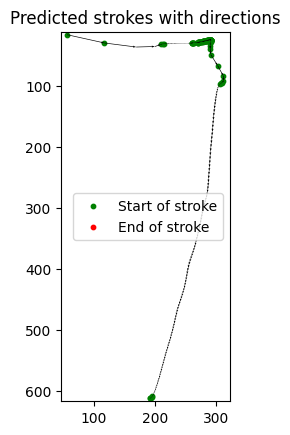

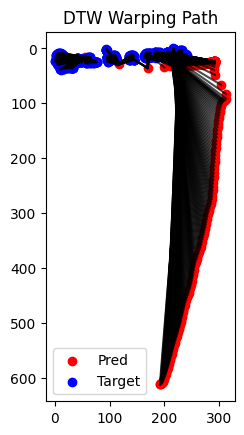

Epoch 7:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 413.6374
   Batch: 100  | Width: 46  | Loss: 288.4066
   Batch: 200  | Width: 56  | Loss: 258.0377
   Batch: 300  | Width: 64  | Loss: 281.8502
   Batch: 400  | Width: 72  | Loss: 241.6221
   Batch: 500  | Width: 78  | Loss: 272.3282
   Batch: 600  | Width: 84  | Loss: 270.7207
   Batch: 700  | Width: 90  | Loss: 275.6059
   Batch: 800  | Width: 96  | Loss: 256.7986
   Batch: 900  | Width: 102 | Loss: 311.1808
   Batch: 1000 | Width: 108 | Loss: 334.4360
   Batch: 1100 | Width: 114 | Loss: 324.8633
   Batch: 1200 | Width: 120 | Loss: 312.9378
   Batch: 1300 | Width: 126 | Loss: 361.9807
   Batch: 1400 | Width: 134 | Loss: 401.3745
   Batch: 1500 | Width: 140 | Loss: 367.1657
   Batch: 1600 | Width: 148 | Loss: 425.6337
   Batch: 1700 | Width: 156 | Loss: 394.5821
   Batch: 1800 | Width: 166 | Loss: 450.7577
   Batch: 1900 | Width: 176 | Loss: 403.8526
   Batch: 2000 | Width: 188 | Loss: 474.0684
   Batch: 2100 | Width: 200 | Loss: 481.7750
   Batch: 

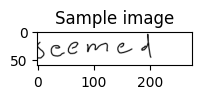

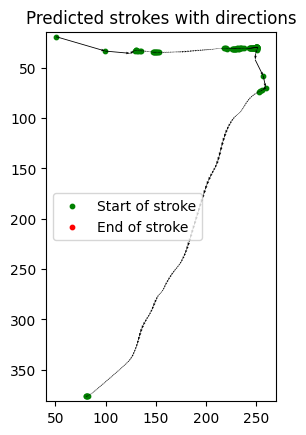

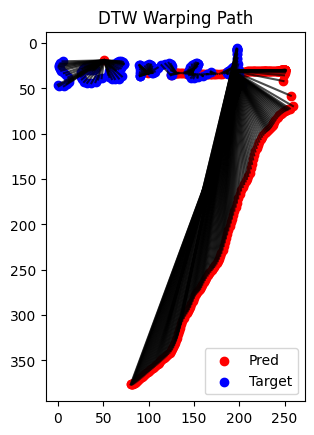

Epoch 8:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 421.5104
   Batch: 100  | Width: 46  | Loss: 267.4059
   Batch: 200  | Width: 56  | Loss: 281.1211
   Batch: 300  | Width: 64  | Loss: 256.4714
   Batch: 400  | Width: 72  | Loss: 226.7090
   Batch: 500  | Width: 78  | Loss: 259.9433
   Batch: 600  | Width: 84  | Loss: 287.3129
   Batch: 700  | Width: 90  | Loss: 299.3042
   Batch: 800  | Width: 96  | Loss: 247.7671
   Batch: 900  | Width: 102 | Loss: 300.3787
   Batch: 1000 | Width: 108 | Loss: 336.9571
   Batch: 1100 | Width: 114 | Loss: 334.4969
   Batch: 1200 | Width: 120 | Loss: 373.2327
   Batch: 1300 | Width: 126 | Loss: 392.4356
   Batch: 1400 | Width: 134 | Loss: 381.6507
   Batch: 1500 | Width: 140 | Loss: 350.9874
   Batch: 1600 | Width: 148 | Loss: 418.8677
   Batch: 1700 | Width: 156 | Loss: 427.2287
   Batch: 1800 | Width: 166 | Loss: 457.4563
   Batch: 1900 | Width: 176 | Loss: 526.6964
   Batch: 2000 | Width: 188 | Loss: 468.3188
   Batch: 2100 | Width: 200 | Loss: 470.2451
   Batch: 

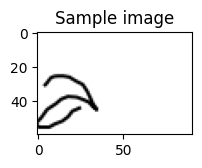

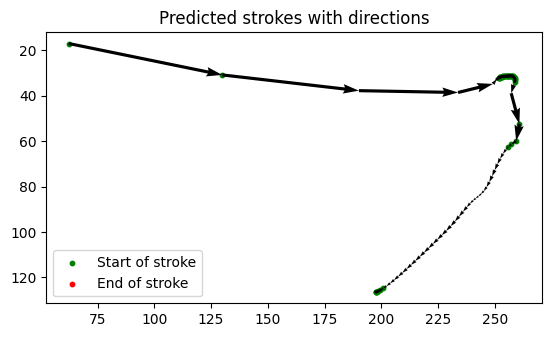

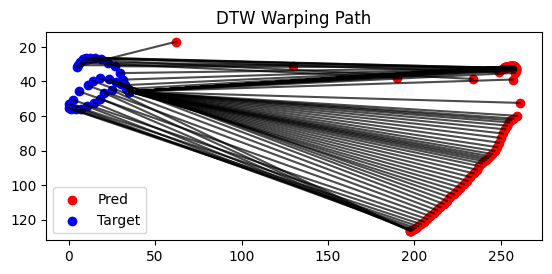

Epoch 9:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 378.1495
   Batch: 100  | Width: 46  | Loss: 267.1732
   Batch: 200  | Width: 56  | Loss: 268.8109
   Batch: 300  | Width: 64  | Loss: 264.8698
   Batch: 400  | Width: 72  | Loss: 234.8610
   Batch: 500  | Width: 78  | Loss: 241.9405
   Batch: 600  | Width: 84  | Loss: 261.9702
   Batch: 700  | Width: 90  | Loss: 268.2972
   Batch: 800  | Width: 96  | Loss: 250.5053
   Batch: 900  | Width: 102 | Loss: 292.0632
   Batch: 1000 | Width: 108 | Loss: 321.8649
   Batch: 1100 | Width: 114 | Loss: 318.7061
   Batch: 1200 | Width: 120 | Loss: 353.8441
   Batch: 1300 | Width: 126 | Loss: 391.7338
   Batch: 1400 | Width: 134 | Loss: 367.0033
   Batch: 1500 | Width: 140 | Loss: 366.4686
   Batch: 1600 | Width: 148 | Loss: 441.4158
   Batch: 1700 | Width: 156 | Loss: 421.2082
   Batch: 1800 | Width: 166 | Loss: 463.3172
   Batch: 1900 | Width: 176 | Loss: 414.8072
   Batch: 2000 | Width: 188 | Loss: 507.2245
   Batch: 2100 | Width: 200 | Loss: 486.7900
   Batch: 

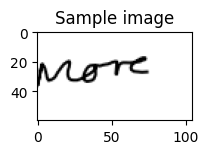

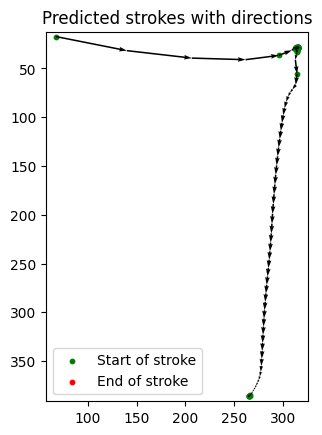

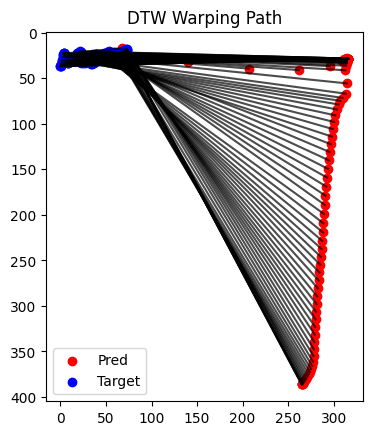

Epoch 10:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 271.8628
   Batch: 100  | Width: 46  | Loss: 261.8510
   Batch: 200  | Width: 56  | Loss: 255.6909
   Batch: 300  | Width: 64  | Loss: 262.3526
   Batch: 400  | Width: 72  | Loss: 256.8210
   Batch: 500  | Width: 78  | Loss: 245.1131
   Batch: 600  | Width: 84  | Loss: 310.3889
   Batch: 700  | Width: 90  | Loss: 263.9582
   Batch: 800  | Width: 96  | Loss: 254.4615
   Batch: 900  | Width: 102 | Loss: 301.3729
   Batch: 1000 | Width: 108 | Loss: 308.6997
   Batch: 1100 | Width: 114 | Loss: 322.8297
   Batch: 1200 | Width: 120 | Loss: 356.7020
   Batch: 1300 | Width: 126 | Loss: 378.7427
   Batch: 1400 | Width: 134 | Loss: 373.9971
   Batch: 1500 | Width: 140 | Loss: 341.0418
   Batch: 1600 | Width: 148 | Loss: 489.2305
   Batch: 1700 | Width: 156 | Loss: 430.9371
   Batch: 1800 | Width: 166 | Loss: 452.8742
   Batch: 1900 | Width: 176 | Loss: 419.7059
   Batch: 2000 | Width: 188 | Loss: 534.4712
   Batch: 2100 | Width: 200 | Loss: 481.9985
   Batch: 

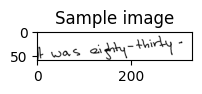

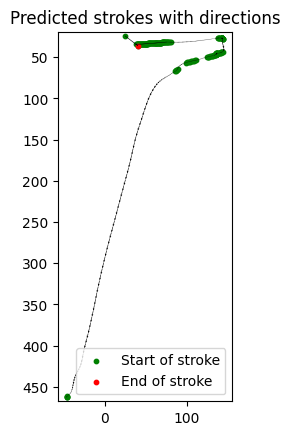

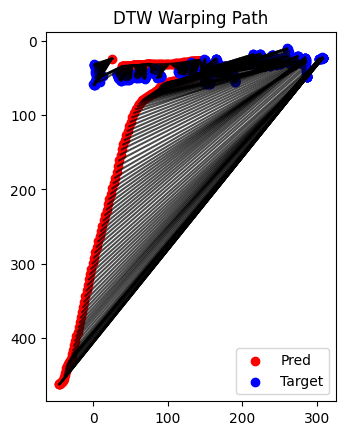

Epoch 11:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 283.9298
   Batch: 100  | Width: 46  | Loss: 274.8226
   Batch: 200  | Width: 56  | Loss: 295.8474
   Batch: 300  | Width: 64  | Loss: 256.0307
   Batch: 400  | Width: 72  | Loss: 218.1700
   Batch: 500  | Width: 78  | Loss: 255.5863
   Batch: 600  | Width: 84  | Loss: 293.0110
   Batch: 700  | Width: 90  | Loss: 302.0685
   Batch: 800  | Width: 96  | Loss: 250.4324
   Batch: 900  | Width: 102 | Loss: 316.1366
   Batch: 1000 | Width: 108 | Loss: 274.4206
   Batch: 1100 | Width: 114 | Loss: 314.8696
   Batch: 1200 | Width: 120 | Loss: 309.1323
   Batch: 1300 | Width: 126 | Loss: 386.1228
   Batch: 1400 | Width: 134 | Loss: 391.0184
   Batch: 1500 | Width: 140 | Loss: 346.5896
   Batch: 1600 | Width: 148 | Loss: 450.3736
   Batch: 1700 | Width: 156 | Loss: 398.3423
   Batch: 1800 | Width: 166 | Loss: 460.0718
   Batch: 1900 | Width: 176 | Loss: 411.7340
   Batch: 2000 | Width: 188 | Loss: 465.1068
   Batch: 2100 | Width: 200 | Loss: 521.2336
   Batch: 

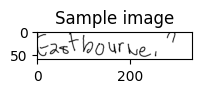

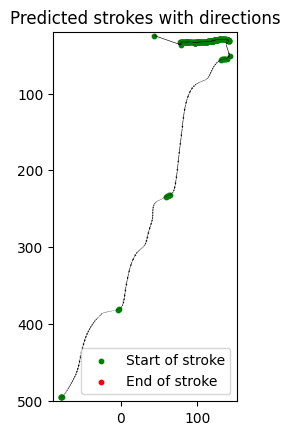

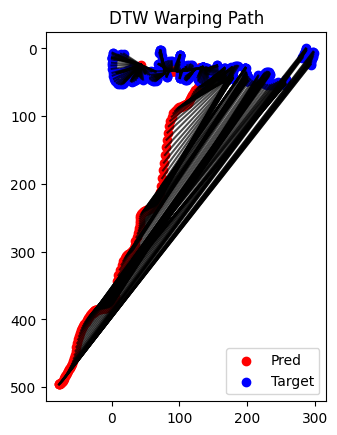

Epoch 12:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 253.2198
   Batch: 100  | Width: 46  | Loss: 265.9605
   Batch: 200  | Width: 56  | Loss: 268.0392
   Batch: 300  | Width: 64  | Loss: 266.3078
   Batch: 400  | Width: 72  | Loss: 219.7981
   Batch: 500  | Width: 78  | Loss: 256.9943
   Batch: 600  | Width: 84  | Loss: 248.4048
   Batch: 700  | Width: 90  | Loss: 266.9993
   Batch: 800  | Width: 96  | Loss: 249.6873
   Batch: 900  | Width: 102 | Loss: 295.6358
   Batch: 1000 | Width: 108 | Loss: 267.8366
   Batch: 1100 | Width: 114 | Loss: 347.6921
   Batch: 1200 | Width: 120 | Loss: 313.5105
   Batch: 1300 | Width: 126 | Loss: 384.7142
   Batch: 1400 | Width: 134 | Loss: 384.1452
   Batch: 1500 | Width: 140 | Loss: 332.0295
   Batch: 1600 | Width: 148 | Loss: 445.2380
   Batch: 1700 | Width: 156 | Loss: 387.8893
   Batch: 1800 | Width: 166 | Loss: 417.0201
   Batch: 1900 | Width: 176 | Loss: 372.6128
   Batch: 2000 | Width: 188 | Loss: 443.2290
   Batch: 2100 | Width: 200 | Loss: 495.2352
   Batch: 

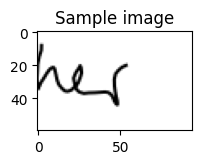

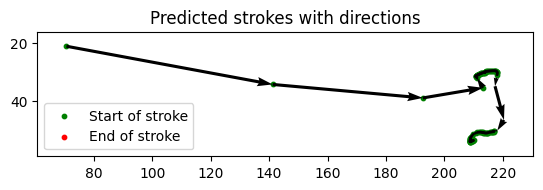

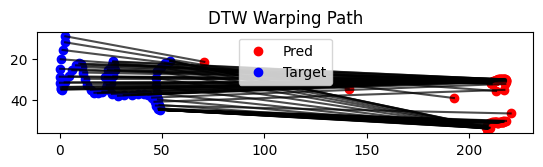

Epoch 13:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 269.5513
   Batch: 100  | Width: 46  | Loss: 255.5662
   Batch: 200  | Width: 56  | Loss: 257.1814
   Batch: 300  | Width: 64  | Loss: 277.9146
   Batch: 400  | Width: 72  | Loss: 215.9251
   Batch: 500  | Width: 78  | Loss: 249.3259
   Batch: 600  | Width: 84  | Loss: 266.1973
   Batch: 700  | Width: 90  | Loss: 274.4962
   Batch: 800  | Width: 96  | Loss: 254.1658
   Batch: 900  | Width: 102 | Loss: 295.6746
   Batch: 1000 | Width: 108 | Loss: 288.7774
   Batch: 1100 | Width: 114 | Loss: 301.7028
   Batch: 1200 | Width: 120 | Loss: 304.2328
   Batch: 1300 | Width: 126 | Loss: 375.8914
   Batch: 1400 | Width: 134 | Loss: 358.5258
   Batch: 1500 | Width: 140 | Loss: 325.9571
   Batch: 1600 | Width: 148 | Loss: 450.6630
   Batch: 1700 | Width: 156 | Loss: 373.6613
   Batch: 1800 | Width: 166 | Loss: 443.4387
   Batch: 1900 | Width: 176 | Loss: 358.5812
   Batch: 2000 | Width: 188 | Loss: 523.5178
   Batch: 2100 | Width: 200 | Loss: 476.2533
   Batch: 

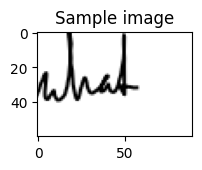

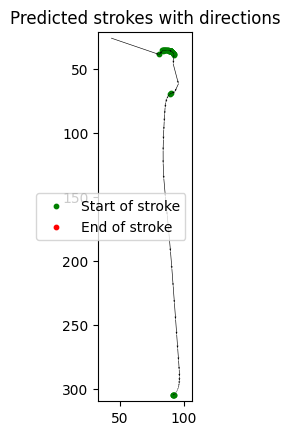

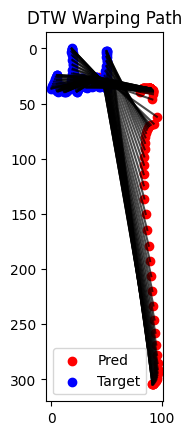

Epoch 14:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 319.4321
   Batch: 100  | Width: 46  | Loss: 253.9154
   Batch: 200  | Width: 56  | Loss: 287.5990
   Batch: 300  | Width: 64  | Loss: 264.1909
   Batch: 400  | Width: 72  | Loss: 233.1107
   Batch: 500  | Width: 78  | Loss: 251.4541
   Batch: 600  | Width: 84  | Loss: 286.1470
   Batch: 700  | Width: 90  | Loss: 267.4132
   Batch: 800  | Width: 96  | Loss: 259.1855
   Batch: 900  | Width: 102 | Loss: 295.9603
   Batch: 1000 | Width: 108 | Loss: 307.4131
   Batch: 1100 | Width: 114 | Loss: 361.6200
   Batch: 1200 | Width: 120 | Loss: 329.8687
   Batch: 1300 | Width: 126 | Loss: 344.7570
   Batch: 1400 | Width: 134 | Loss: 358.2343
   Batch: 1500 | Width: 140 | Loss: 338.3188
   Batch: 1600 | Width: 148 | Loss: 472.2997
   Batch: 1700 | Width: 156 | Loss: 415.7951
   Batch: 1800 | Width: 166 | Loss: 457.4840
   Batch: 1900 | Width: 176 | Loss: 379.1947
   Batch: 2000 | Width: 188 | Loss: 465.5001
   Batch: 2100 | Width: 200 | Loss: 521.7025
   Batch: 

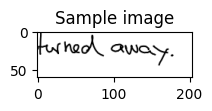

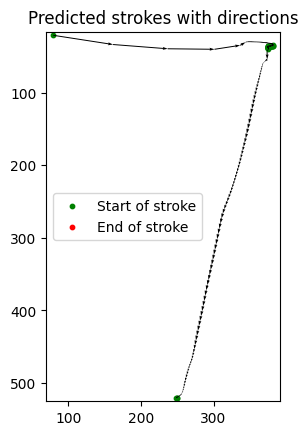

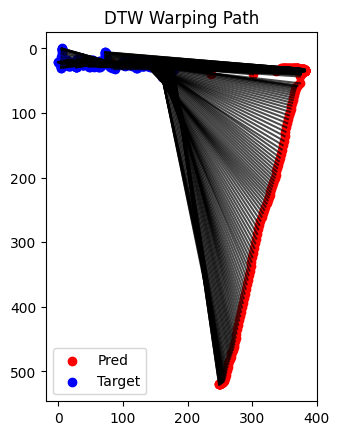

Epoch 15:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 278.1303
   Batch: 100  | Width: 46  | Loss: 242.9904
   Batch: 200  | Width: 56  | Loss: 271.3983
   Batch: 300  | Width: 64  | Loss: 266.1474
   Batch: 400  | Width: 72  | Loss: 199.5436
   Batch: 500  | Width: 78  | Loss: 240.4330
   Batch: 600  | Width: 84  | Loss: 276.3282
   Batch: 700  | Width: 90  | Loss: 266.5558
   Batch: 800  | Width: 96  | Loss: 271.0553
   Batch: 900  | Width: 102 | Loss: 300.7780
   Batch: 1000 | Width: 108 | Loss: 313.0646
   Batch: 1100 | Width: 114 | Loss: 328.6889
   Batch: 1200 | Width: 120 | Loss: 301.2325
   Batch: 1300 | Width: 126 | Loss: 359.7837
   Batch: 1400 | Width: 134 | Loss: 387.5842
   Batch: 1500 | Width: 140 | Loss: 347.4107
   Batch: 1600 | Width: 148 | Loss: 454.6551
   Batch: 1700 | Width: 156 | Loss: 410.8722
   Batch: 1800 | Width: 166 | Loss: 460.1731
   Batch: 1900 | Width: 176 | Loss: 425.2276
   Batch: 2000 | Width: 188 | Loss: 521.0495
   Batch: 2100 | Width: 200 | Loss: 524.6167
   Batch: 

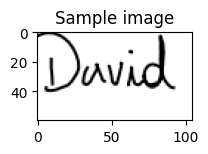

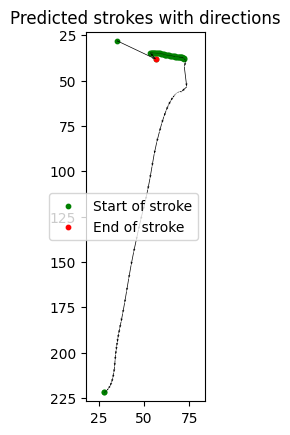

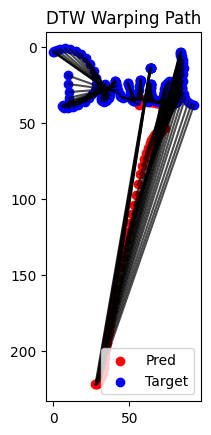

Epoch 16:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 256.6829
   Batch: 100  | Width: 46  | Loss: 247.8949
   Batch: 200  | Width: 56  | Loss: 264.7391
   Batch: 300  | Width: 64  | Loss: 260.0123
   Batch: 400  | Width: 72  | Loss: 218.0341
   Batch: 500  | Width: 78  | Loss: 264.9824
   Batch: 600  | Width: 84  | Loss: 294.5779
   Batch: 700  | Width: 90  | Loss: 272.1366
   Batch: 800  | Width: 96  | Loss: 222.6550
   Batch: 900  | Width: 102 | Loss: 277.5748
   Batch: 1000 | Width: 108 | Loss: 290.3641
   Batch: 1100 | Width: 114 | Loss: 312.6758
   Batch: 1200 | Width: 120 | Loss: 280.5149
   Batch: 1300 | Width: 126 | Loss: 360.1191
   Batch: 1400 | Width: 134 | Loss: 370.0371
   Batch: 1500 | Width: 140 | Loss: 332.9055
   Batch: 1600 | Width: 148 | Loss: 416.8413
   Batch: 1700 | Width: 156 | Loss: 404.7127
   Batch: 1800 | Width: 166 | Loss: 456.5638
   Batch: 1900 | Width: 176 | Loss: 374.9209
   Batch: 2000 | Width: 188 | Loss: 508.6609
   Batch: 2100 | Width: 200 | Loss: 485.6493
   Batch: 

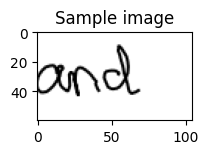

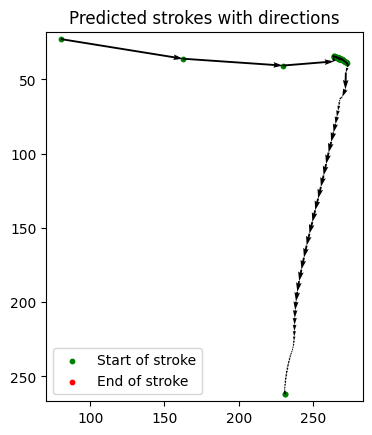

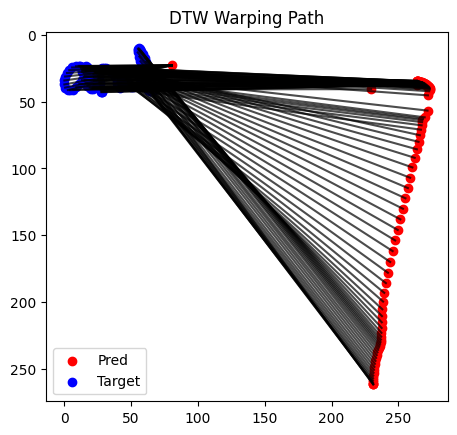

Epoch 17:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 216.3308
   Batch: 100  | Width: 46  | Loss: 246.8836
   Batch: 200  | Width: 56  | Loss: 263.9267
   Batch: 300  | Width: 64  | Loss: 265.6621
   Batch: 400  | Width: 72  | Loss: 225.3201
   Batch: 500  | Width: 78  | Loss: 271.7323
   Batch: 600  | Width: 84  | Loss: 272.6738
   Batch: 700  | Width: 90  | Loss: 286.5959
   Batch: 800  | Width: 96  | Loss: 253.3441
   Batch: 900  | Width: 102 | Loss: 296.2147
   Batch: 1000 | Width: 108 | Loss: 277.6191
   Batch: 1100 | Width: 114 | Loss: 285.1399
   Batch: 1200 | Width: 120 | Loss: 297.6342
   Batch: 1300 | Width: 126 | Loss: 322.0440
   Batch: 1400 | Width: 134 | Loss: 366.0477
   Batch: 1500 | Width: 140 | Loss: 325.8184
   Batch: 1600 | Width: 148 | Loss: 441.5032
   Batch: 1700 | Width: 156 | Loss: 379.8769
   Batch: 1800 | Width: 166 | Loss: 444.9128
   Batch: 1900 | Width: 176 | Loss: 414.7822
   Batch: 2000 | Width: 188 | Loss: 486.3727
   Batch: 2100 | Width: 200 | Loss: 460.3065
   Batch: 

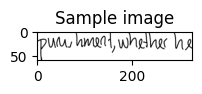

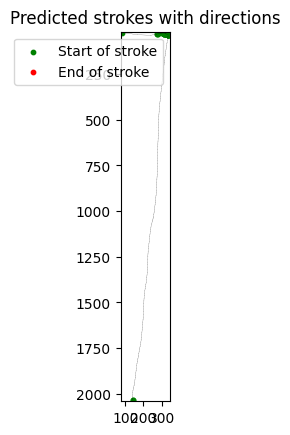

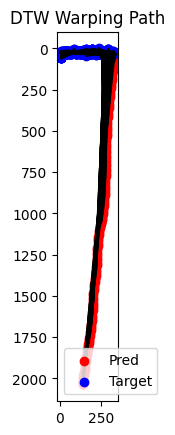

Epoch 18:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 214.7429
   Batch: 100  | Width: 46  | Loss: 239.3464
   Batch: 200  | Width: 56  | Loss: 259.3428
   Batch: 300  | Width: 64  | Loss: 252.4970
   Batch: 400  | Width: 72  | Loss: 219.5349
   Batch: 500  | Width: 78  | Loss: 262.4292
   Batch: 600  | Width: 84  | Loss: 282.7163
   Batch: 700  | Width: 90  | Loss: 273.6007
   Batch: 800  | Width: 96  | Loss: 267.4527
   Batch: 900  | Width: 102 | Loss: 291.2821
   Batch: 1000 | Width: 108 | Loss: 315.8822
   Batch: 1100 | Width: 114 | Loss: 329.5714
   Batch: 1200 | Width: 120 | Loss: 291.7688
   Batch: 1300 | Width: 126 | Loss: 318.8812
   Batch: 1400 | Width: 134 | Loss: 355.3880
   Batch: 1500 | Width: 140 | Loss: 333.8047
   Batch: 1600 | Width: 148 | Loss: 444.0608
   Batch: 1700 | Width: 156 | Loss: 388.7298
   Batch: 1800 | Width: 166 | Loss: 458.5440
   Batch: 1900 | Width: 176 | Loss: 388.6229
   Batch: 2000 | Width: 188 | Loss: 441.5379
   Batch: 2100 | Width: 200 | Loss: 505.3585
   Batch: 

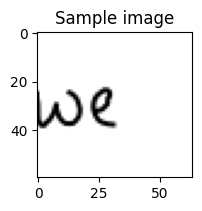

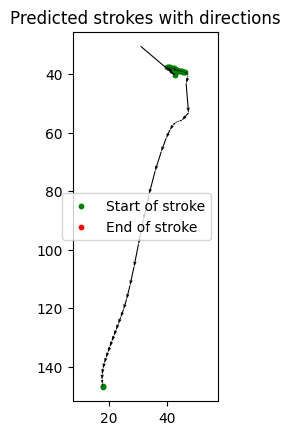

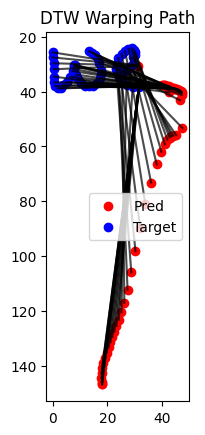

Epoch 19:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 217.5837
   Batch: 100  | Width: 46  | Loss: 236.5740
   Batch: 200  | Width: 56  | Loss: 257.8785
   Batch: 300  | Width: 64  | Loss: 248.1052
   Batch: 400  | Width: 72  | Loss: 213.6182
   Batch: 500  | Width: 78  | Loss: 269.8758
   Batch: 600  | Width: 84  | Loss: 249.5284
   Batch: 700  | Width: 90  | Loss: 281.7025
   Batch: 800  | Width: 96  | Loss: 252.0672
   Batch: 900  | Width: 102 | Loss: 278.1055
   Batch: 1000 | Width: 108 | Loss: 324.9100
   Batch: 1100 | Width: 114 | Loss: 270.1071
   Batch: 1200 | Width: 120 | Loss: 292.0593
   Batch: 1300 | Width: 126 | Loss: 350.4963
   Batch: 1400 | Width: 134 | Loss: 372.2878
   Batch: 1500 | Width: 140 | Loss: 301.8562
   Batch: 1600 | Width: 148 | Loss: 455.8418
   Batch: 1700 | Width: 156 | Loss: 414.1583
   Batch: 1800 | Width: 166 | Loss: 457.0415
   Batch: 1900 | Width: 176 | Loss: 387.0262
   Batch: 2000 | Width: 188 | Loss: 466.1693
   Batch: 2100 | Width: 200 | Loss: 495.6724
   Batch: 

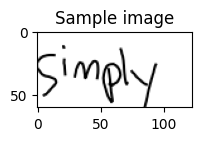

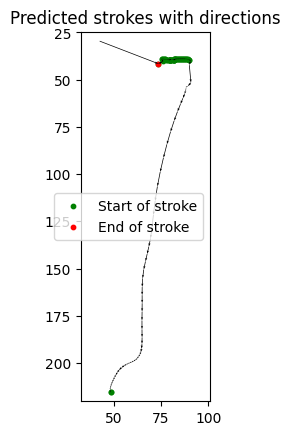

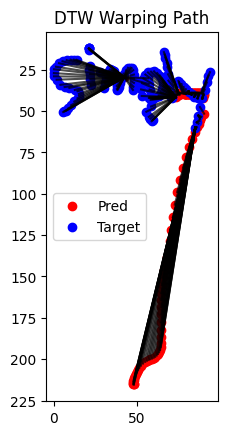

Epoch 20:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 226.1363
   Batch: 100  | Width: 46  | Loss: 244.0338
   Batch: 200  | Width: 56  | Loss: 249.7982
   Batch: 300  | Width: 64  | Loss: 258.0116
   Batch: 400  | Width: 72  | Loss: 209.6287
   Batch: 500  | Width: 78  | Loss: 275.9435
   Batch: 600  | Width: 84  | Loss: 264.2475
   Batch: 700  | Width: 90  | Loss: 276.8112
   Batch: 800  | Width: 96  | Loss: 274.9048
   Batch: 900  | Width: 102 | Loss: 280.2937
   Batch: 1000 | Width: 108 | Loss: 300.2871
   Batch: 1100 | Width: 114 | Loss: 328.5470
   Batch: 1200 | Width: 120 | Loss: 289.3805
   Batch: 1300 | Width: 126 | Loss: 368.8132
   Batch: 1400 | Width: 134 | Loss: 334.7489
   Batch: 1500 | Width: 140 | Loss: 348.4546
   Batch: 1600 | Width: 148 | Loss: 439.7045
   Batch: 1700 | Width: 156 | Loss: 381.2908
   Batch: 1800 | Width: 166 | Loss: 479.2800
   Batch: 1900 | Width: 176 | Loss: 366.0348
   Batch: 2000 | Width: 188 | Loss: 502.2839
   Batch: 2100 | Width: 200 | Loss: 484.1220
   Batch: 

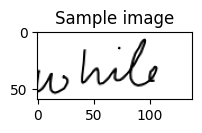

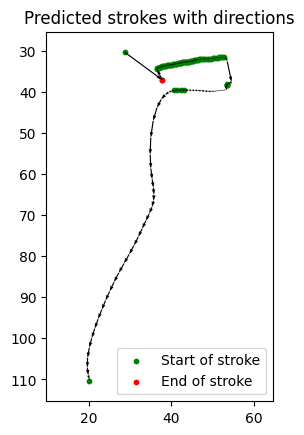

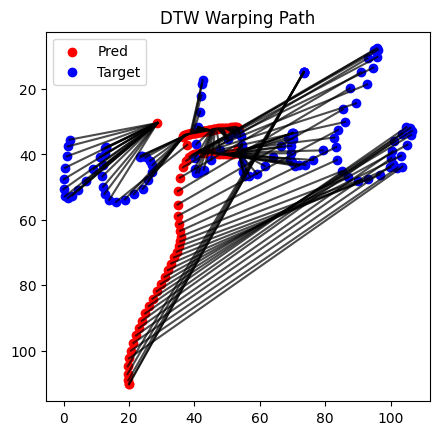

Epoch 21:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 196.4851
   Batch: 100  | Width: 46  | Loss: 247.8376
   Batch: 200  | Width: 56  | Loss: 249.7934
   Batch: 300  | Width: 64  | Loss: 256.6621
   Batch: 400  | Width: 72  | Loss: 211.6489
   Batch: 500  | Width: 78  | Loss: 283.5542
   Batch: 600  | Width: 84  | Loss: 241.8853
   Batch: 700  | Width: 90  | Loss: 271.6040
   Batch: 800  | Width: 96  | Loss: 242.5431
   Batch: 900  | Width: 102 | Loss: 282.2712
   Batch: 1000 | Width: 108 | Loss: 284.0376
   Batch: 1100 | Width: 114 | Loss: 290.0096
   Batch: 1200 | Width: 120 | Loss: 270.4405
   Batch: 1300 | Width: 126 | Loss: 373.0851
   Batch: 1400 | Width: 134 | Loss: 386.8063
   Batch: 1500 | Width: 140 | Loss: 336.1340
   Batch: 1600 | Width: 148 | Loss: 439.4752
   Batch: 1700 | Width: 156 | Loss: 376.9238
   Batch: 1800 | Width: 166 | Loss: 457.0945
   Batch: 1900 | Width: 176 | Loss: 361.8425
   Batch: 2000 | Width: 188 | Loss: 438.4332
   Batch: 2100 | Width: 200 | Loss: 467.5233
   Batch: 

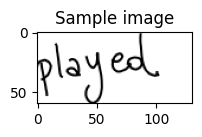

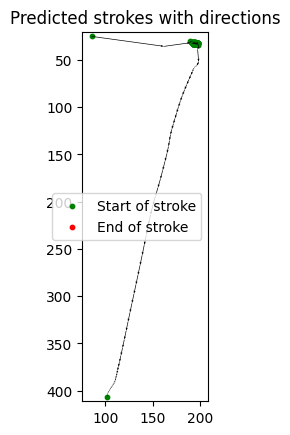

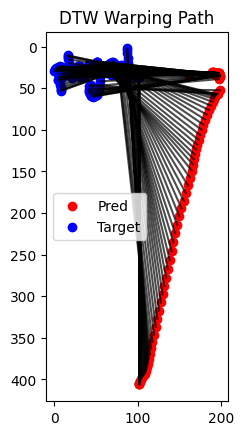

Epoch 22:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 201.4641
   Batch: 100  | Width: 46  | Loss: 242.4099
   Batch: 200  | Width: 56  | Loss: 253.3915
   Batch: 300  | Width: 64  | Loss: 246.3380
   Batch: 400  | Width: 72  | Loss: 214.0125
   Batch: 500  | Width: 78  | Loss: 267.7464
   Batch: 600  | Width: 84  | Loss: 257.7015
   Batch: 700  | Width: 90  | Loss: 298.7713
   Batch: 800  | Width: 96  | Loss: 256.7020
   Batch: 900  | Width: 102 | Loss: 257.1344
   Batch: 1000 | Width: 108 | Loss: 292.0557
   Batch: 1100 | Width: 114 | Loss: 309.5133
   Batch: 1200 | Width: 120 | Loss: 298.6948
   Batch: 1300 | Width: 126 | Loss: 333.1752
   Batch: 1400 | Width: 134 | Loss: 353.4266
   Batch: 1500 | Width: 140 | Loss: 348.6791
   Batch: 1600 | Width: 148 | Loss: 460.7642
   Batch: 1700 | Width: 156 | Loss: 395.8368
   Batch: 1800 | Width: 166 | Loss: 471.6404
   Batch: 1900 | Width: 176 | Loss: 358.0816
   Batch: 2000 | Width: 188 | Loss: 469.6427
   Batch: 2100 | Width: 200 | Loss: 477.0889
   Batch: 

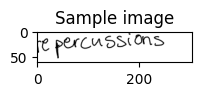

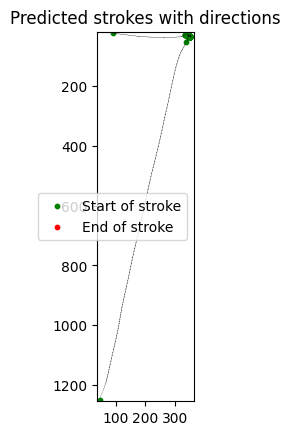

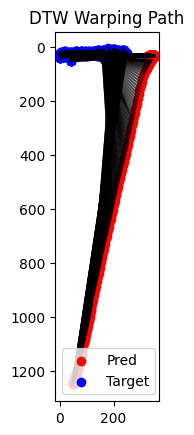

Epoch 23:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 187.6727
   Batch: 100  | Width: 46  | Loss: 241.9533
   Batch: 200  | Width: 56  | Loss: 249.3499
   Batch: 300  | Width: 64  | Loss: 250.1839
   Batch: 400  | Width: 72  | Loss: 217.9077
   Batch: 500  | Width: 78  | Loss: 296.5135
   Batch: 600  | Width: 84  | Loss: 271.0230
   Batch: 700  | Width: 90  | Loss: 273.8154
   Batch: 800  | Width: 96  | Loss: 266.0348
   Batch: 900  | Width: 102 | Loss: 274.8418
   Batch: 1000 | Width: 108 | Loss: 280.4848
   Batch: 1100 | Width: 114 | Loss: 307.7911
   Batch: 1200 | Width: 120 | Loss: 307.3042
   Batch: 1300 | Width: 126 | Loss: 332.4892
   Batch: 1400 | Width: 134 | Loss: 357.0516
   Batch: 1500 | Width: 140 | Loss: 340.4191
   Batch: 1600 | Width: 148 | Loss: 481.7479
   Batch: 1700 | Width: 156 | Loss: 430.0841
   Batch: 1800 | Width: 166 | Loss: 443.4723
   Batch: 1900 | Width: 176 | Loss: 374.8454
   Batch: 2000 | Width: 188 | Loss: 427.8094
   Batch: 2100 | Width: 200 | Loss: 449.2083
   Batch: 

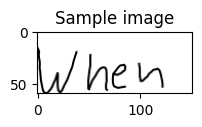

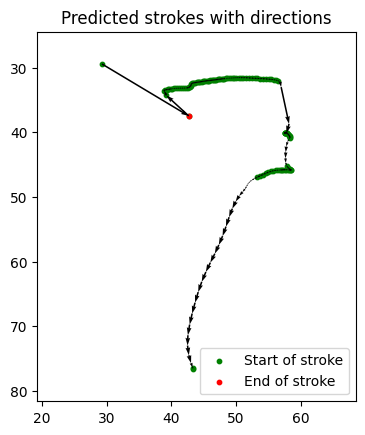

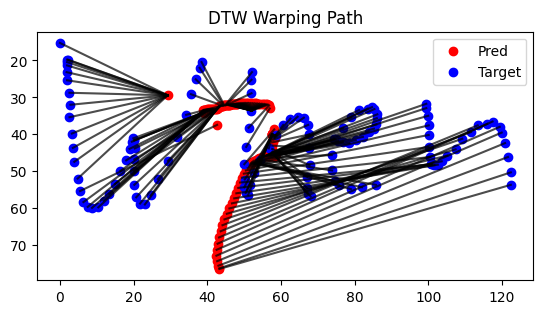

Epoch 24:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 191.7657
   Batch: 100  | Width: 46  | Loss: 253.4090
   Batch: 200  | Width: 56  | Loss: 258.4658
   Batch: 300  | Width: 64  | Loss: 243.4126
   Batch: 400  | Width: 72  | Loss: 208.8914
   Batch: 500  | Width: 78  | Loss: 287.6675
   Batch: 600  | Width: 84  | Loss: 255.5222
   Batch: 700  | Width: 90  | Loss: 277.9228
   Batch: 800  | Width: 96  | Loss: 274.0002
   Batch: 900  | Width: 102 | Loss: 266.7892
   Batch: 1000 | Width: 108 | Loss: 262.5287
   Batch: 1100 | Width: 114 | Loss: 348.2888
   Batch: 1200 | Width: 120 | Loss: 299.6880
   Batch: 1300 | Width: 126 | Loss: 332.3337
   Batch: 1400 | Width: 134 | Loss: 382.2323
   Batch: 1500 | Width: 140 | Loss: 391.8714
   Batch: 1600 | Width: 148 | Loss: 447.5108
   Batch: 1700 | Width: 156 | Loss: 390.1792
   Batch: 1800 | Width: 166 | Loss: 475.3405
   Batch: 1900 | Width: 176 | Loss: 357.4749
   Batch: 2000 | Width: 188 | Loss: 475.2654
   Batch: 2100 | Width: 200 | Loss: 481.5747
   Batch: 

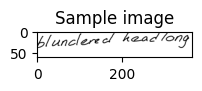

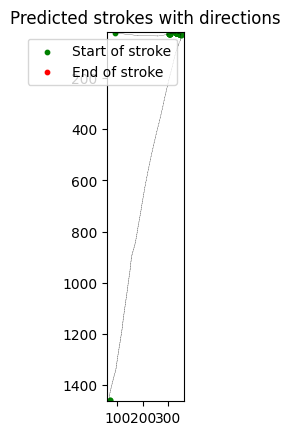

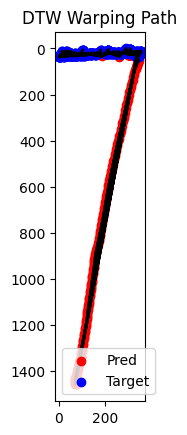

Epoch 25:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 206.4819
   Batch: 100  | Width: 46  | Loss: 254.7262
   Batch: 200  | Width: 56  | Loss: 266.7981
   Batch: 300  | Width: 64  | Loss: 242.3583
   Batch: 400  | Width: 72  | Loss: 208.2798
   Batch: 500  | Width: 78  | Loss: 276.9659
   Batch: 600  | Width: 84  | Loss: 267.9000
   Batch: 700  | Width: 90  | Loss: 283.4067
   Batch: 800  | Width: 96  | Loss: 245.6531
   Batch: 900  | Width: 102 | Loss: 275.1765
   Batch: 1000 | Width: 108 | Loss: 283.1835
   Batch: 1100 | Width: 114 | Loss: 303.8809
   Batch: 1200 | Width: 120 | Loss: 291.7450
   Batch: 1300 | Width: 126 | Loss: 345.4231
   Batch: 1400 | Width: 134 | Loss: 358.7351
   Batch: 1500 | Width: 140 | Loss: 365.0004
   Batch: 1600 | Width: 148 | Loss: 431.1934
   Batch: 1700 | Width: 156 | Loss: 402.5032
   Batch: 1800 | Width: 166 | Loss: 463.9067
   Batch: 1900 | Width: 176 | Loss: 379.7005
   Batch: 2000 | Width: 188 | Loss: 449.8945
   Batch: 2100 | Width: 200 | Loss: 478.9488
   Batch: 

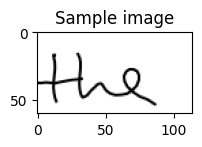

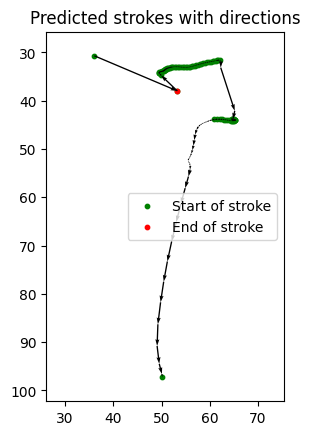

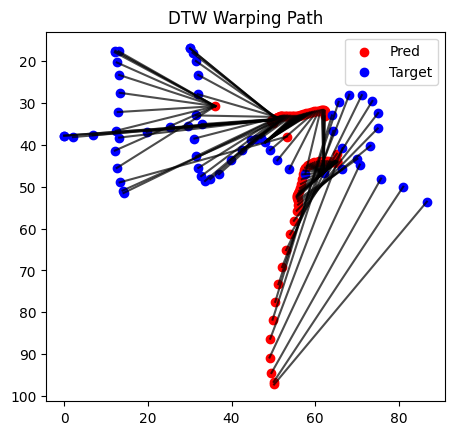

Epoch 26:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 202.3401
   Batch: 100  | Width: 46  | Loss: 260.4412
   Batch: 200  | Width: 56  | Loss: 249.5865
   Batch: 300  | Width: 64  | Loss: 252.9909
   Batch: 400  | Width: 72  | Loss: 200.5469
   Batch: 500  | Width: 78  | Loss: 263.3875
   Batch: 600  | Width: 84  | Loss: 276.0595
   Batch: 700  | Width: 90  | Loss: 274.6919
   Batch: 800  | Width: 96  | Loss: 278.1274
   Batch: 900  | Width: 102 | Loss: 273.6391
   Batch: 1000 | Width: 108 | Loss: 276.1267
   Batch: 1100 | Width: 114 | Loss: 293.4460
   Batch: 1200 | Width: 120 | Loss: 279.6552
   Batch: 1300 | Width: 126 | Loss: 330.7584
   Batch: 1400 | Width: 134 | Loss: 360.7920
   Batch: 1500 | Width: 140 | Loss: 332.7277
   Batch: 1600 | Width: 148 | Loss: 436.6597
   Batch: 1700 | Width: 156 | Loss: 369.8987
   Batch: 1800 | Width: 166 | Loss: 445.5873
   Batch: 1900 | Width: 176 | Loss: 367.5655
   Batch: 2000 | Width: 188 | Loss: 444.6592
   Batch: 2100 | Width: 200 | Loss: 513.9753
   Batch: 

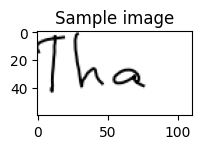

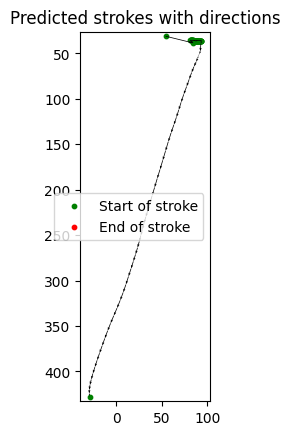

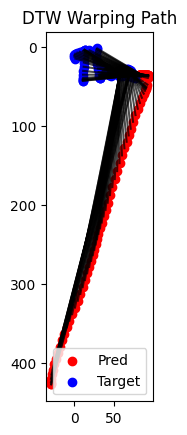

Epoch 27:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 191.9509
   Batch: 100  | Width: 46  | Loss: 245.5703
   Batch: 200  | Width: 56  | Loss: 257.4692
   Batch: 300  | Width: 64  | Loss: 236.0450
   Batch: 400  | Width: 72  | Loss: 216.3124
   Batch: 500  | Width: 78  | Loss: 277.0071
   Batch: 600  | Width: 84  | Loss: 275.4576
   Batch: 700  | Width: 90  | Loss: 284.4271
   Batch: 800  | Width: 96  | Loss: 265.0806
   Batch: 900  | Width: 102 | Loss: 266.6004
   Batch: 1000 | Width: 108 | Loss: 282.6905
   Batch: 1100 | Width: 114 | Loss: 324.0341
   Batch: 1200 | Width: 120 | Loss: 275.7097
   Batch: 1300 | Width: 126 | Loss: 334.1743
   Batch: 1400 | Width: 134 | Loss: 356.0749
   Batch: 1500 | Width: 140 | Loss: 351.4093
   Batch: 1600 | Width: 148 | Loss: 434.7998
   Batch: 1700 | Width: 156 | Loss: 374.1716
   Batch: 1800 | Width: 166 | Loss: 456.2203
   Batch: 1900 | Width: 176 | Loss: 377.6518
   Batch: 2000 | Width: 188 | Loss: 423.7680
   Batch: 2100 | Width: 200 | Loss: 482.2299
   Batch: 

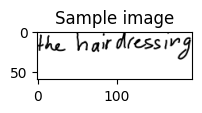

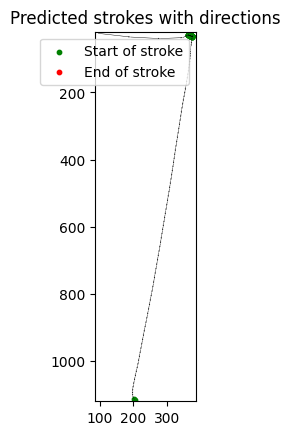

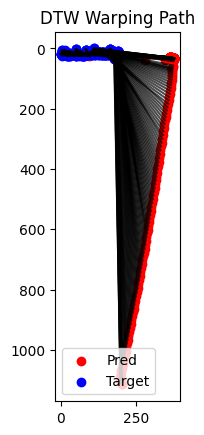

Epoch 28:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 215.3301
   Batch: 100  | Width: 46  | Loss: 251.7161
   Batch: 200  | Width: 56  | Loss: 270.4106
   Batch: 300  | Width: 64  | Loss: 242.5196
   Batch: 400  | Width: 72  | Loss: 209.2265
   Batch: 500  | Width: 78  | Loss: 278.7464
   Batch: 600  | Width: 84  | Loss: 265.0180
   Batch: 700  | Width: 90  | Loss: 271.6670
   Batch: 800  | Width: 96  | Loss: 243.3354
   Batch: 900  | Width: 102 | Loss: 274.3343
   Batch: 1000 | Width: 108 | Loss: 280.4093
   Batch: 1100 | Width: 114 | Loss: 315.7482
   Batch: 1200 | Width: 120 | Loss: 283.8196
   Batch: 1300 | Width: 126 | Loss: 324.0636
   Batch: 1400 | Width: 134 | Loss: 356.2231
   Batch: 1500 | Width: 140 | Loss: 335.9643
   Batch: 1600 | Width: 148 | Loss: 415.5001
   Batch: 1700 | Width: 156 | Loss: 391.5743
   Batch: 1800 | Width: 166 | Loss: 456.5667
   Batch: 1900 | Width: 176 | Loss: 376.5938
   Batch: 2000 | Width: 188 | Loss: 416.7274
   Batch: 2100 | Width: 200 | Loss: 450.6077
   Batch: 

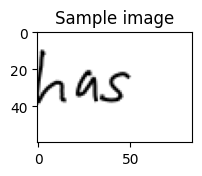

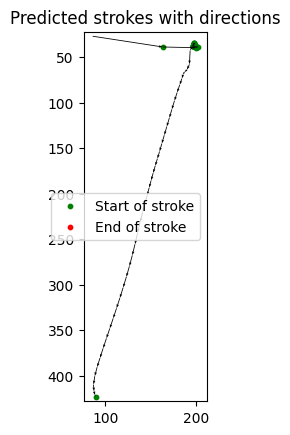

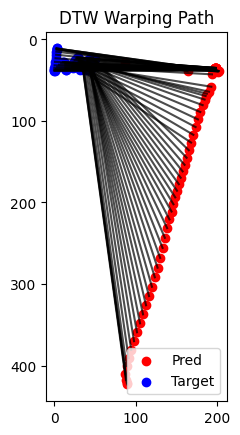

Epoch 29:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 194.3495
   Batch: 100  | Width: 46  | Loss: 245.2197
   Batch: 200  | Width: 56  | Loss: 255.7637
   Batch: 300  | Width: 64  | Loss: 250.3573
   Batch: 400  | Width: 72  | Loss: 214.4245
   Batch: 500  | Width: 78  | Loss: 273.4647
   Batch: 600  | Width: 84  | Loss: 251.9179
   Batch: 700  | Width: 90  | Loss: 275.5833
   Batch: 800  | Width: 96  | Loss: 269.1733
   Batch: 900  | Width: 102 | Loss: 270.4539
   Batch: 1000 | Width: 108 | Loss: 277.8124
   Batch: 1100 | Width: 114 | Loss: 308.6421
   Batch: 1200 | Width: 120 | Loss: 288.0628
   Batch: 1300 | Width: 126 | Loss: 374.9356
   Batch: 1400 | Width: 134 | Loss: 359.2583
   Batch: 1500 | Width: 140 | Loss: 334.2793
   Batch: 1600 | Width: 148 | Loss: 458.7520
   Batch: 1700 | Width: 156 | Loss: 384.3935
   Batch: 1800 | Width: 166 | Loss: 447.7369
   Batch: 1900 | Width: 176 | Loss: 364.2887
   Batch: 2000 | Width: 188 | Loss: 450.5887
   Batch: 2100 | Width: 200 | Loss: 480.3712
   Batch: 

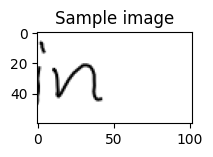

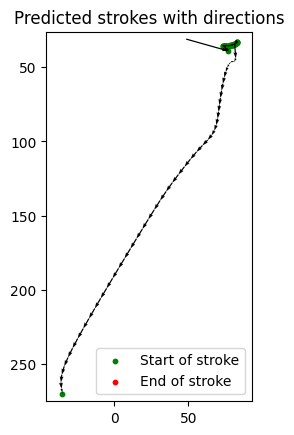

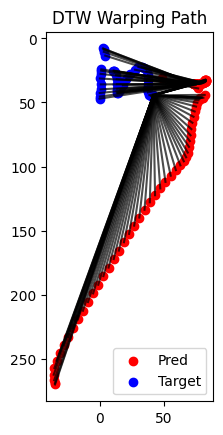

Epoch 30:   0%|          | 0/2649 [00:00<?, ?it/s]

   Batch: 0    | Width: 6   | Loss: 172.5604
   Batch: 100  | Width: 46  | Loss: 245.6447
   Batch: 200  | Width: 56  | Loss: 242.3823
   Batch: 300  | Width: 64  | Loss: 247.9953
   Batch: 400  | Width: 72  | Loss: 220.1532
   Batch: 500  | Width: 78  | Loss: 264.4902
   Batch: 600  | Width: 84  | Loss: 273.7316
   Batch: 700  | Width: 90  | Loss: 278.3384
   Batch: 800  | Width: 96  | Loss: 274.6900
   Batch: 900  | Width: 102 | Loss: 262.2923
   Batch: 1000 | Width: 108 | Loss: 285.4021
   Batch: 1100 | Width: 114 | Loss: 325.1085


In [ ]:
# Fitting the model
losses = model_fit(model, dataloader, loss_function, optimizer, scheduler, num_epochs, device, checkpoint_interval, root_dir, plot=True)